<a href="https://colab.research.google.com/github/geoc1234/sourdough/blob/development/notebooks/HeatMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

weight 0.9500176184455534


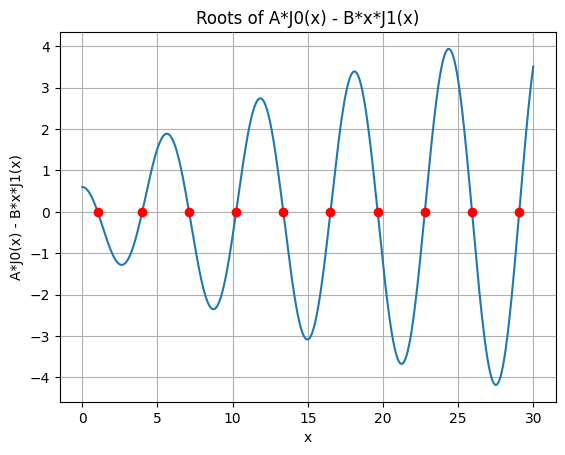

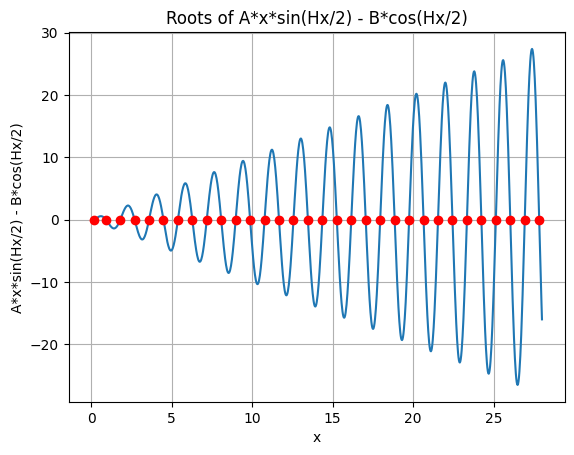

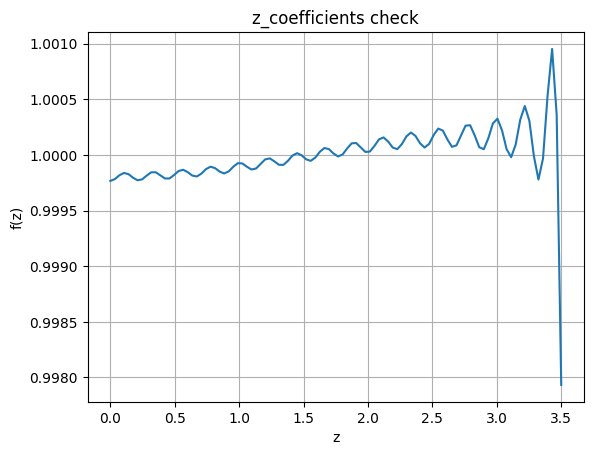

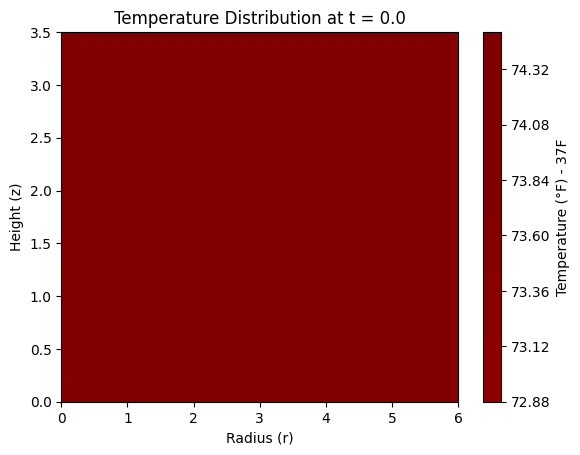

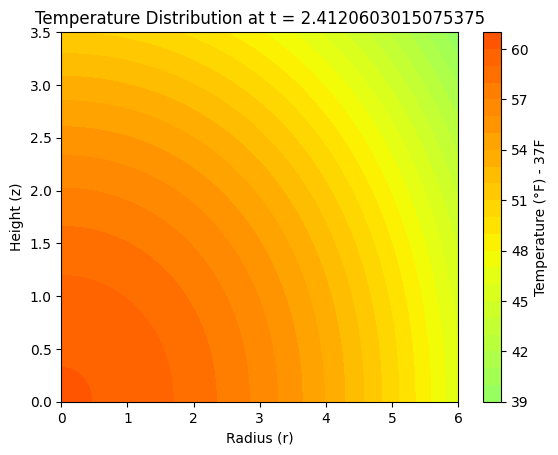

shape T:  (50, 50, 200)


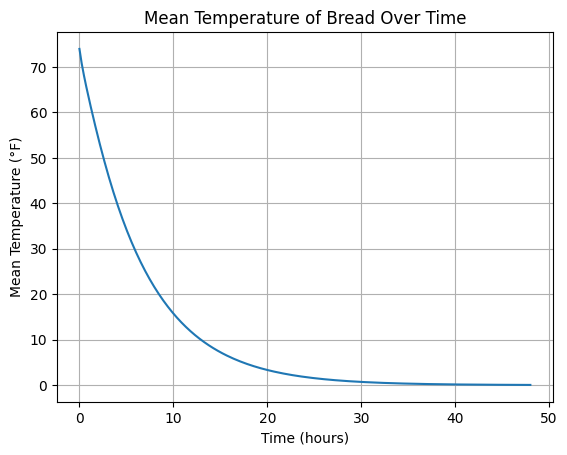

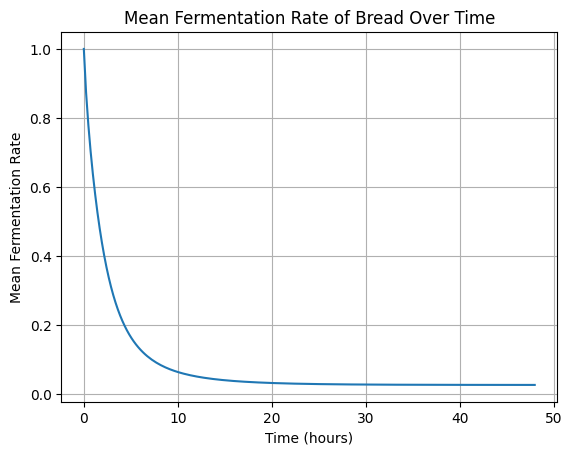

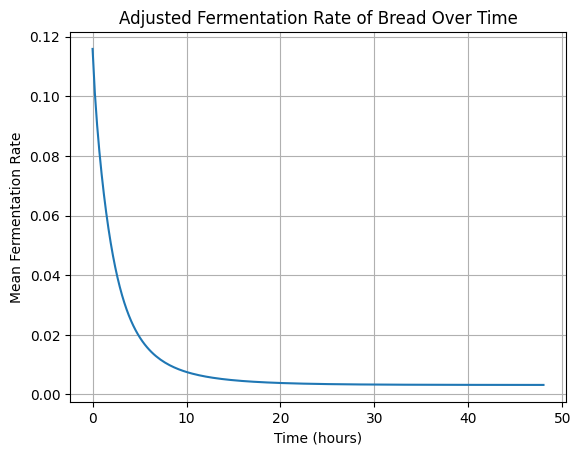

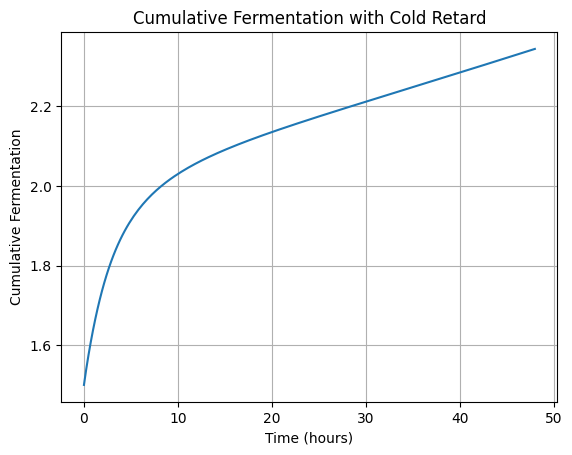

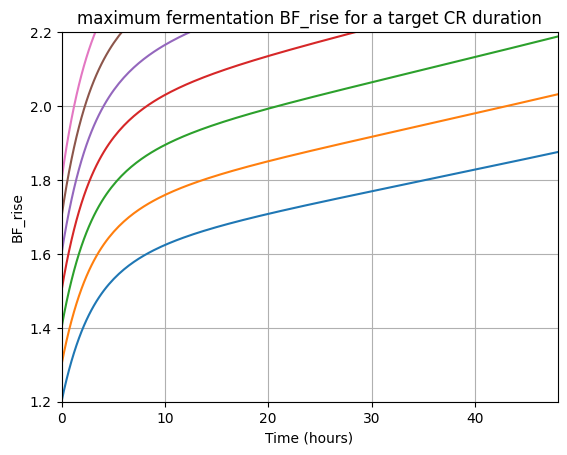

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1, j0, jn_zeros


# Define parameters
T_air = 0.0  # The refrigerator air temperature °F
T_0 = 74.0    # The initial bread temperature °F
radius = 6.0 # 2.0       # radius of the cylindrically shaped bread cm
height = 7.0 # 5.0       # height or length of the bread cm
convection_h = 0.00020   # Example value for 'h'
conduction_k = 0.002 # 0.00363  # Example value for 'k'
cp = 2092.0
rho = 0.0012
alpha = (cp*rho/conduction_k/3600) #0.1convert from sec to hrs
weight_boule = (np.pi*radius**2)*height*rho
print("weight",weight_boule)

num_roots_l = 50 # Number of terms for summation over l
num_roots_m = 50  # Number of terms for summation over m

r_resolution = 50 # Number of r-axis points
z_resolution = 50 # Number of z-axis points
t_resolution = 200 # Number of t-axis points

# Create arrays for plotting
r = np.linspace(0, radius,r_resolution )
z = np.linspace(0, height/2,z_resolution)
t = np.linspace(0, 48, t_resolution)  # Time in hrs

# Create a meshgrid for r and z
r_mesh, z_mesh = np.meshgrid(r, z)

# Initialize an empty array to store the temperature
# The shape now includes time
# create a (r_resolution, z_resolution, t_resolution) array for the Temperature field
T = np.zeros_like(r_mesh[..., None] * t[None, None, :])

def find_roots_lambda(A, B, x_range=(0,radius,1000), n_roots=num_roots_l):
    """
    Finds the roots of the equation A*J0(x) - B*x*J1(x) = 0 within a specified range.

    Args:
        A: Constant coefficient for J0(x).
        B: Constant coefficient for x*J1(x).
        x_range: Tuple specifying the range for searching roots.
        n_roots: The number of roots to find.

    Returns:
        A NumPy array containing the approximate roots of the equation.

    """
    roots = []
    x = np.linspace(x_range[0], x_range[1], x_range[2])
    y = A * j0(x) - B * x * j1(x)

    # Find zero crossings
    for i in range(len(x)-1):
      if (y[i] > 0 and y[i+1] < 0) or (y[i] < 0 and y[i+1] > 0):
        root = x[i] - y[i] * (x[i+1] - x[i])/(y[i+1] - y[i])
        roots.append(root)
        if len(roots) == n_roots:
          break;

    return np.array(roots)

def find_roots_m(A, B, H = height, x_range=(0,height,1000), n_roots=num_roots_m):
    """
    Finds the roots of the equation A*x*sin(x) - B*cos(x) = 0 within a specified range.

    Args:
        A: Constant coefficient for x*sin(x).
        B: Constant coefficient for cos(x).
        x_range: Tuple specifying the range for searching roots.
        n_roots: The number of roots to find.

    Returns:
        A NumPy array containing the approximate roots of the equation.

    """
    roots = []
    x = np.linspace(x_range[0], x_range[1],x_range[2])
    y = A * x * np.sin(x * (H/2)) - B * np.cos(x * (H/2))

    # Find zero crossings
    for i in range(len(x)-1):
      if (y[i] > 0 and y[i+1] < 0) or (y[i] < 0 and y[i+1] > 0):
        root = x[i] - y[i] * (x[i+1] - x[i])/(y[i+1] - y[i])
        roots.append(root)
      if len(roots) == n_roots:
        break;
    return np.array(roots)

def calc_coefficient_l(xl, a=9):
  # expects input xl = lambda_l*a
  term1 = 2.0/(radius**2 * (j0(xl)**2 + j1(xl)**2))
  term2 = a**2*j1(xl)/xl
  #print("coeff", term1*term2)
  return term1*term2

def calc_coefficient_z(xz,H=7):
  # expects input xz = root_m
  term1 = (H/2) + np.sin(xz*H)/(2*xz)
  term2 = (2/xz)*np.sin(xz*H/2)
  return term2/term1

A = (convection_h/conduction_k)*radius
B = 1
l_rootsRange = 5*radius
l_range=(0,l_rootsRange,10000)
roots_l = find_roots_lambda(A, B,l_range, num_roots_l)
x = np.linspace(0,l_rootsRange,1000)
y = A * j0(x) - B * x * j1(x)
plt.plot(x, y)
plt.plot(roots_l, np.zeros_like(roots_l), "ro")
plt.xlabel("x")
plt.ylabel("A*J0(x) - B*x*J1(x)")
plt.title("Roots of A*J0(x) - B*x*J1(x)")
plt.grid(True)
plt.show()

A = 1
B = (convection_h/conduction_k)
rootsRange = 4*height
zroots=[0, rootsRange, 1000]
roots_m = find_roots_m(A, B, height, zroots, n_roots= num_roots_m)
x = np.linspace(zroots[0],zroots[1],zroots[2])
y = A  * x * np.sin(x*height/2) - B * np.cos(x * height/2)
plt.plot(x, y)
plt.plot(roots_m, np.zeros_like(roots_m), "ro")
plt.xlabel("x")
plt.ylabel("A*x*sin(Hx/2) - B*cos(Hx/2)")
plt.title("Roots of A*x*sin(Hx/2) - B*cos(Hx/2)")
plt.grid(True)
plt.show()

# check coefficient calcs by confirming initial condition is ~ 1.0 across entire domain
z_check = np.linspace(0,height/2,100)
fz = np.zeros_like(z_check)
for n in range(0, len(roots_m)):
  m_root = roots_m[n-1]
  fz += calc_coefficient_z(m_root,height) * np.cos((m_root * z_check))
plt.plot(z_check,fz)
plt.xlabel("z")
plt.ylabel("f(z)")
plt.title("z_coefficients check")
plt.grid(True)
plt.show()

# Calculate the temperature at each point in the mesh
for l in range(0, len(roots_l)):
    # Use square brackets to access elements of the roots_j0 array
    xl = roots_l[l-1]
    lambda_l = xl/radius
    for n in range(0, len(roots_m)):
        m_root = roots_m[n-1]
        exp_term = np.exp(-(((lambda_l)**2 + (m_root**2)) * t[None, None, :]) / alpha)
        T +=  (T_0 - T_air)* (j0(lambda_l * r_mesh[..., None]) * calc_coefficient_l(xl, radius)) * \
        calc_coefficient_z(m_root,height) * np.cos((m_root * z_mesh[..., None])) * exp_term

# Add the air temperature to the result
T += T_air

# Plot the temperature distribution at a specific time (e.g.,t=49)
time_index = 0 # Time index
dr = radius/r_resolution

plt.contourf(r_mesh, z_mesh, T[:,:,time_index], levels=20, cmap='jet', vmin=T_air, vmax=T_0)
plt.colorbar(label='Temperature (°F) - 37F')
plt.xlabel('Radius (r)')
plt.ylabel('Height (z)')
plt.title('Temperature Distribution at t = {}'.format(t[time_index]))
plt.show()
plt.show()

time_index = 10 # Time index (0-199)
plt.contourf(r_mesh, z_mesh, T[:,:,time_index], levels=20, cmap='jet', vmin=T_air, vmax=T_0)
plt.colorbar(label='Temperature (°F) - 37F')
plt.xlabel('Radius (r)')
plt.ylabel('Height (z)')
plt.title('Temperature Distribution at t = {}'.format(t[time_index]))
plt.show()
plt.show()

# Extract the mean temperature at each time step
# Activation energy (J/mol/K)
E_a = 55000.0
# Gas constant (J/mol/K)
R = 8.314
mean_temperatures = np.mean(T, axis=(0, 1))
weighted_mean_temperatures = []
weighted_mean_temperatures_Kelvin = []

print(f'shape T: ', np.shape(T))

for i in range (0,len(t)):
  weighted_mean_temperatures.append(np.sum(np.mean(T[:,:,i],axis=1)*(2.0*r*dr)/np.pow(radius,2),axis=0))

weighted_mean_temperatures_Kelvin = (np.array(weighted_mean_temperatures) + 40.0)/1.8 + 233.15

mean_reaction_rate = (np.exp(-E_a / (R * weighted_mean_temperatures_Kelvin)))
k0 = mean_reaction_rate[0]
mean_reaction_rate /= k0

# Create the plot
plt.plot(t, weighted_mean_temperatures)
plt.xlabel('Time (hours)')
plt.ylabel('Mean Temperature (°F)')
plt.title('Mean Temperature of Bread Over Time')
plt.grid(True)
plt.show()

# Create the plot
plt.plot(t, mean_reaction_rate)
plt.xlabel('Time (hours)')
plt.ylabel('Mean Fermentation Rate')
plt.title('Mean Fermentation Rate of Bread Over Time')
plt.grid(True)
plt.show()

# Integrate the rate equation numerically to get the cumulative amount of fermentation occuring during cold retard.
"""
use doubling of the dough as a termination point, and expressing a starting point as the amount of rise achieved prior to start
of cold retard.
"""
# Use the rate of rise from the bulk fermentation phase to estimate the activity of the starter
BF_rise_time = 3.5 # hours (assumes the induction time has been subtracted)
BF_rise_amount = 1.5 # amount of rise achieved prior to cold retard
actual_rate = (np.log(BF_rise_amount)/BF_rise_time) # Because this is based on data from the Bulk fermentation phase, the temperature = T0.
mean_reaction_rate *= actual_rate
# Create the plot
plt.plot(t, mean_reaction_rate)
plt.xlabel('Time (hours)')
plt.ylabel('Mean Fermentation Rate')
plt.title('Adjusted Fermentation Rate of Bread Over Time')
plt.grid(True)
plt.show()

# Numerical integration (trapezoidal rule) accounting for the effect of cooling on the rate constant, k.
dt = t[1] - t[0]  # Time step
cumulative_fermentation = np.zeros_like(t)
cumulative_fermentation[0] = BF_rise_amount

for i in range(1, len(t)):
  cumulative_fermentation[i] = cumulative_fermentation[i - 1] + 0.5 * dt * (mean_reaction_rate[i-1] + mean_reaction_rate[i]) * cumulative_fermentation[i - 1]

# Plot the cumulative amount of fermentation
plt.plot(t, cumulative_fermentation)
plt.xlabel('Time (hours)')
plt.ylabel('Cumulative Fermentation')
plt.title('Cumulative Fermentation with Cold Retard')
plt.grid(True)
plt.show()

'''
invert the fermentation curve to find the target starting point
'''
factor_0 = 2/cumulative_fermentation[len(t)-1]
cumulative_fermentation *= factor_0
factor_1 = cumulative_fermentation[0]
yset_0 = np.zeros_like(t)
yset_1 = np.zeros_like(t)
yset_2 = np.zeros_like(t)
yset_3 = np.zeros_like(t)
yset_4 = np.zeros_like(t)
yset_5 = np.zeros_like(t)
yset_6 = np.zeros_like(t)
yset_0 = cumulative_fermentation * 1.2/factor_1
yset_1 = cumulative_fermentation * 1.3/factor_1
yset_2 = cumulative_fermentation * 1.4/factor_1
yset_3 = cumulative_fermentation * 1.5/factor_1
yset_4 = cumulative_fermentation * 1.6/factor_1
yset_5 = cumulative_fermentation * 1.7/factor_1
yset_6 = cumulative_fermentation * 1.8/factor_1
#plt.plot(t,cumulative_fermentation)
plt.plot(t,yset_0)
plt.plot(t,yset_1)
plt.plot(t,yset_2)
plt.plot(t,yset_3)
plt.plot(t,yset_4)
plt.plot(t,yset_5)
plt.plot(t,yset_6)
plt.ylim(1.2,2.2)
plt.xlim(0,48)
plt.xlabel('Time (hours)')
plt.ylabel('BF_rise')
plt.title('maximum fermentation BF_rise for a target CR duration')
plt.grid(True)
plt.show()